# Prepare data

In [ ]:
# install libraries
!pip install PyGithub
!pip install pandasql

In [2]:
# import csv
import pandas as pd
from datetime import datetime, timedelta, timezone
from github import Github

# Constants
repo_name = "sqlalchemy/sqlalchemy"
token = "token"

# Function to get commit information from a Git repo
def get_commit_info(repo_name, token):
    gh = Github(token)
    
    # Get the repository
    repo = gh.get_repo(repo_name)
    
    # Get the commits
    commits = repo.get_commits()
    
    # Calculate the date 6 months ago from today
    six_months_ago = datetime.now(timezone.utc) - timedelta(days=6*30)
    
    # Extract the records
    commit_info = []
    for commit in commits:
        commit_datetime = commit.commit.author.date
        if commit_datetime <= six_months_ago:
            committer_name = commit.commit.author.name
            commit_info.append([commit_datetime, committer_name])
    
    return commit_info

commit_info = get_commit_info(repo_name, token)
df = pd.DataFrame(commit_info, columns=['commit_datetime', 'committer_name'])

print(df.head(5))

            commit_datetime    committer_name
0 2023-12-21 17:14:00+00:00        Mike Bayer
1 2024-03-15 18:15:27+00:00  Federico Caselli
2 2024-06-08 14:43:45+00:00     Michael Bayer
3 2024-06-04 14:56:26+00:00        Mike Bayer
4 2024-06-06 13:53:04+00:00     Michael Bayer


# 1. Top 5 committers ranked by count of commits

In [35]:
from pandasql import sqldf

print(sqldf(
    '''
    SELECT committer_name, COUNT(1) as commit_count
    FROM df
    GROUP BY committer_name
    ORDER BY COUNT(1) DESC
    LIMIT 5;
    '''))

     committer_name  commit_count
0        Mike Bayer         11876
1        mike bayer          1692
2    Jason Kirtland           515
3  Federico Caselli           502
4     Michael Trier           200


# 2. Top commit streak by day

In [45]:
from pandasql import sqldf

print(sqldf(
    '''
    SELECT committer_name, 
           MIN(commit_date) AS start_date, 
           MAX(commit_date) AS end_date, 
           COUNT(*) AS streak_length
    FROM (
        SELECT committer_name, 
               DATE(commit_datetime) AS commit_date,
               DATE(commit_datetime) - ROW_NUMBER() OVER (PARTITION BY committer_name ORDER BY DATE(commit_datetime)) AS streak_group
        FROM df
    ) AS streaks
    GROUP BY committer_name, streak_group
    ORDER BY streak_length DESC
    '''))

        committer_name  start_date    end_date  streak_length
0      Nils Philippsen  2015-11-09  2021-11-13              5
1      Nils Philippsen  2015-12-08  2023-02-28              4
2           Tony Locke  2014-07-26  2023-06-19              4
3          Alex Gaynor  2011-03-16  2014-04-26              3
4         Diana Clarke  2013-03-30  2016-01-28              3
...                ...         ...         ...            ...
16817     Éric Lemoine  2012-09-12  2012-09-12              1
16818     Éric Lemoine  2012-09-12  2012-09-12              1
16819     Éric Lemoine  2012-09-12  2012-09-12              1
16820     Éric Lemoine  2012-09-11  2012-09-11              1
16821     Катаев Денис  2017-03-17  2017-03-17              1

[16822 rows x 4 columns]


# 3. Overall commit heatmap

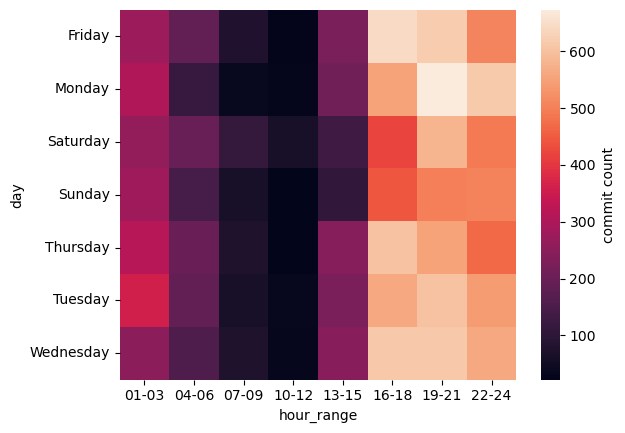

In [38]:
# pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_hour_range(dt):
    hour = dt.hour
    start_hour = (hour // 3) * 3 + 1
    end_hour = start_hour + 2
    return f"{start_hour:02d}-{end_hour:02d}"

# Step 1: Get weekday and hour_range columns
heatmap_df = df.copy()
heatmap_df['day'] = heatmap_df['commit_datetime'].dt.day_name()
heatmap_df['hour_range'] = heatmap_df['commit_datetime'].apply(get_hour_range)

# Step 2: Calculate counts for each group
grouped_counts = heatmap_df.groupby(['day', 'hour_range']).size().reset_index(name='count')

# Step 3: Merge counts back into the original DataFrame
heatmap_df = heatmap_df.merge(grouped_counts, on=['day', 'hour_range'], how='left')

# Plot heatmap
df_heatmap = heatmap_df.pivot_table(values='count', index='day', columns='hour_range')
sns.heatmap(df_heatmap, cbar_kws={'label': 'commit count'})
plt.show()